In [1]:
%%time

from utils.utils import create_dataset, Trainer
from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cpu].
CPU times: user 1.87 s, sys: 458 ms, total: 2.32 s
Wall time: 1.36 s


In [2]:
%%time

dataset = create_dataset('criteo', sample_num=100000, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 4.08 s, sys: 297 ms, total: 4.38 s
Wall time: 4.38 s


In [3]:
lgbm = LGBMClassifier(
    learning_rate=0.1,
    n_estimators=10230,
    num_leaves=31,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8, 
    metric='auc',
    objective='binary'
)


In [4]:
def transform(lgbm, train_X, train_y, valid_X, valid_y, test_X, test_y):
    train_X, train_y, valid_X, valid_y, test_X, test_y =\
        train_X.to(device), train_y.to(device), valid_X.to(device),\
        valid_y.to(device), test_X.to(device), test_y.to(device)
    
    # One-hot Encoding
    ohe = OneHotEncoder()
    sparse_mat = ohe.fit_transform(np.vstack([train_X, valid_X, test_X]))
    train_len, valid_len, test_len = len(train_X), len(valid_X), len(test_X)
    sparse_train_X = sparse_mat[:train_len]
    sparse_valid_X = sparse_mat[train_len: -test_len]
    sparse_test_X = sparse_mat[-test_len:]
    
    # lgbm fit transoform
    lgbm.fit(sparse_train_X, train_y, eval_set=[(sparse_valid_X, valid_y)], verbose=100, early_stopping_rounds=100)
    fusion_train_X = np.hstack([lgbm.predict(sparse_train_X, pred_leaf=True), train_X])
    fusion_valid_X = np.hstack([lgbm.predict(sparse_valid_X, pred_leaf=True), valid_X])
    fusion_test_X = np.hstack([lgbm.predict(sparse_test_X, pred_leaf=True), test_X])
    fusion_field_dims = (np.vstack([fusion_train_X, fusion_valid_X, fusion_test_X]).max(axis=0) + 1).tolist()
    
    fusion_train_X = torch.tensor(fusion_train_X, dtype=torch.long).to(device)
    fusion_valid_X = torch.tensor(fusion_valid_X, dtype=torch.long).to(device)
    fusion_test_X = torch.tensor(fusion_test_X, dtype=torch.long).to(device)
    return fusion_field_dims, fusion_train_X, fusion_valid_X, fusion_test_X


In [5]:
class LogisticRegression(nn.Module):
    
    def __init__(self, field_dims):
        super(LogisticRegression, self).__init__()
        
        self.bias = nn.Parameter(torch.zeros((1, )))
        self.embed = FeaturesEmbedding(field_dims, 1)

    def forward(self, x):
        # x shape: (batch_size, num_fields)
        output = self.embed(x).sum(dim=1) + self.bias
        output = torch.sigmoid(output)
        return output


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.743871
[200]	valid_0's auc: 0.749403
[300]	valid_0's auc: 0.752053
[400]	valid_0's auc: 0.754077
[500]	valid_0's auc: 0.754923
[600]	valid_0's auc: 0.755349
[700]	valid_0's auc: 0.755947
[800]	valid_0's auc: 0.756366
[900]	valid_0's auc: 0.756653
Early stopping, best iteration is:
[889]	valid_0's auc: 0.756748


 30%|██▉       | 179/600 [01:48<04:15,  1.65it/s]


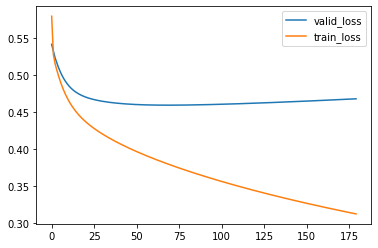

train_loss: 0.37077 | train_metric: 0.87436
valid_loss: 0.45937 | valid_metric: 0.76450
test_loss:  0.44324 | test_auc:  0.77266
CPU times: user 10min 22s, sys: 22.9 s, total: 10min 44s
Wall time: 2min 2s


In [6]:
%%time

field_dims, train_X, valid_X, test_X = transform(lgbm, train_X, train_y, valid_X, valid_y, test_X, test_y)

LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

lr = LogisticRegression(field_dims).to(device)
optimizer = optim.Adam(lr.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(lr, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_auc = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_auc))
